# Data Preparation - Parnamirim

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy.stats import pearsonr
import readHistData as hist

## 1. Load Observed Data from CSV

In [16]:
df = pd.read_csv('../data/Parnamirim.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 26 rows of data


,ADT_Areia,ADT_Emaus,ADT_Liberdade,OVT_Areia,OVT_Emaus,OVT_Liberdade,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,0.042735,0.012658,0.039024,4.654867,4.617391,1.038961,2009_12,0.000,23.512798,25.678571,28.719940
1,0.017167,0.000000,0.000000,15.095652,12.811966,17.025000,2010_01,21.150,24.186310,26.067262,28.677976
2,0.017021,0.042194,0.008333,24.042373,21.840336,26.940171,2010_02,20.675,24.247619,26.334524,29.205952
3,0.008333,0.042017,0.021459,28.487179,10.974790,32.982906,2010_03,14.725,25.206190,27.262738,30.158214
4,0.025000,0.017167,0.029661,21.973913,3.533333,21.383333,2010_04,20.775,25.283929,27.104762,29.754167


In [ ]:
days = [i * 30 for i in range(len(df))]

AreiaOVT = df['OVT_Areia'].ffill().bfill().values
EmausOVT = df['OVT_Emaus'].ffill().bfill().values
LiberdadeOVT = df['OVT_Liberdade'].ffill().bfill().values

AreiaADT = df['ADT_Areia'].ffill().bfill().values
EmausADT = df['ADT_Emaus'].ffill().bfill().values
LiberdadeADT = df['ADT_Liberdade'].ffill().bfill().values

print(f"Days: {days[:5]}... to {days[-5:]}")
print(f"Number of time points: {len(days)}")

Days: [0, 30, 60, 90, 120]... to [630, 660, 690, 720, 750]
Number of time points: 26


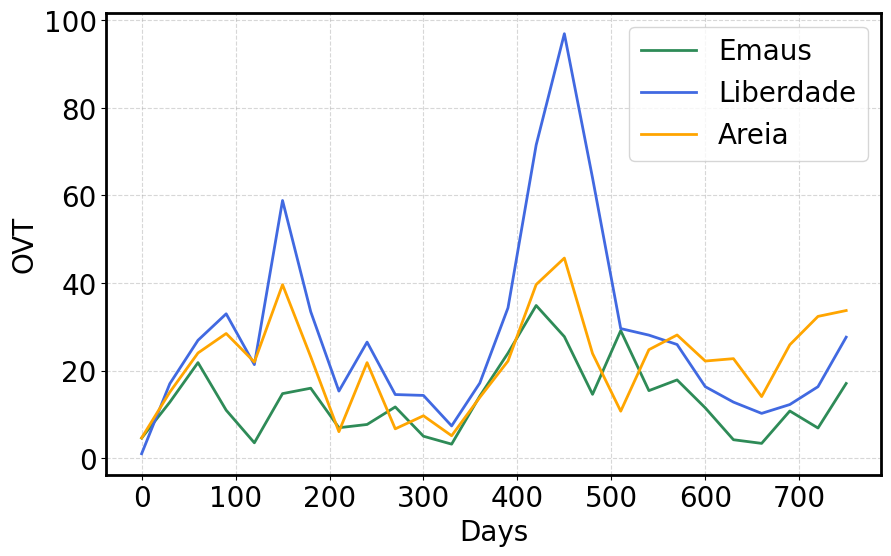

In [33]:
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 2,
    'axes.linewidth': 2      # Espessura das bordas dos eixos
})

plt.figure(figsize=(10, 6))
plt.plot(days, EmausOVT, label='Emaus', color='seagreen')
plt.plot(days, LiberdadeOVT, label='Liberdade', color='royalblue')
plt.plot(days, AreiaOVT, label='Areia', color='orange')
plt.legend(fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.ylabel("OVT", fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

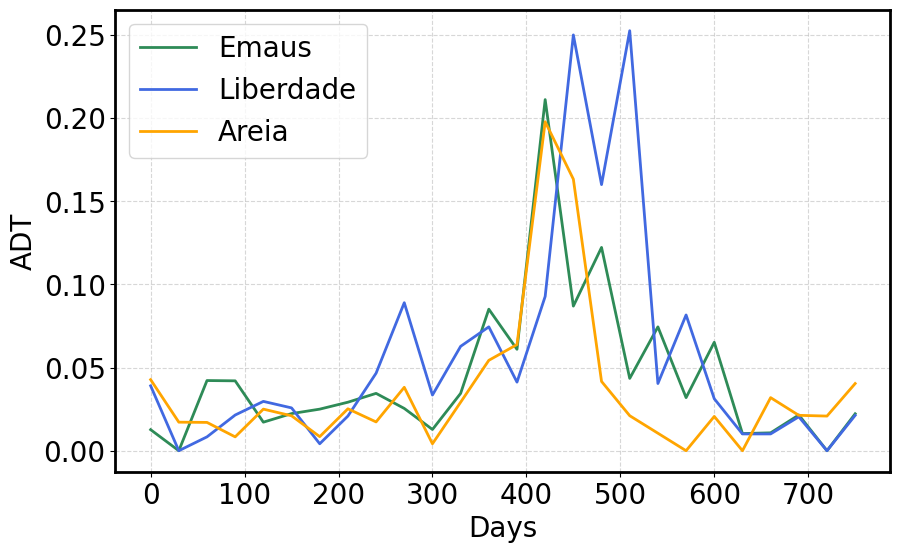

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(days, EmausADT, label='Emaus', color='seagreen')
plt.plot(days, LiberdadeADT, label='Liberdade', color='royalblue')
plt.plot(days, AreiaADT, label='Areia', color='orange')
plt.legend(fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.ylabel("ADT", fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 2. Extract Terrain Proportions from Maps

In [19]:
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50:
        return True
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:
            return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    step = 3
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            if isWater(pixel_map):
                water += 1
            elif isStreet(pixel_map):
                streets += 1
            elif isGreen(pixel_sat):
                parks += 1
            else:
                houses += 1
    return [water, parks, streets, houses]

In [20]:
neighborhoods = ['Areia', 'Emaus', 'Liberdade']
map_base_path = '../maps/Parnamirim_RN'

proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

Processing Areia...
  Raw counts [water, parks, streets, houses]: [0, 12836, 31489, 138004]
Processing Emaus...
  Raw counts [water, parks, streets, houses]: [0, 12243, 36715, 133371]
Processing Liberdade...
  Raw counts [water, parks, streets, houses]: [0, 47996, 22599, 111734]


In [21]:
proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")
print("\nProportions Matrix:")
print(matProporcoes)

Proportions [water, parks, streets, houses]:
  Areia: water=0.0000, parks=0.0704, streets=0.1727, houses=0.7569
  Emaus: water=0.0000, parks=0.0671, streets=0.2014, houses=0.7315
  Liberdade: water=0.0000, parks=0.2632, streets=0.1239, houses=0.6128

Proportions Matrix:
[[0.         0.07040021 0.17270429 0.7568955 ]
 [0.         0.06714785 0.20136676 0.73148539]
 [0.         0.26323843 0.12394627 0.6128153 ]]


## 3. Decompose OVT Data

In [22]:
O_agua, O_parque, O_rua, O_casa = [], [], [], []
OVT_data = [AreiaOVT, EmausOVT, LiberdadeOVT]

for t in range(len(days)):
    vetOvo = [OVT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua, O_parque, O_rua, O_casa = np.array(O_agua), np.array(O_parque), np.array(O_rua), np.array(O_casa)
print("OVT decomposition complete.")

OVT decomposition complete.


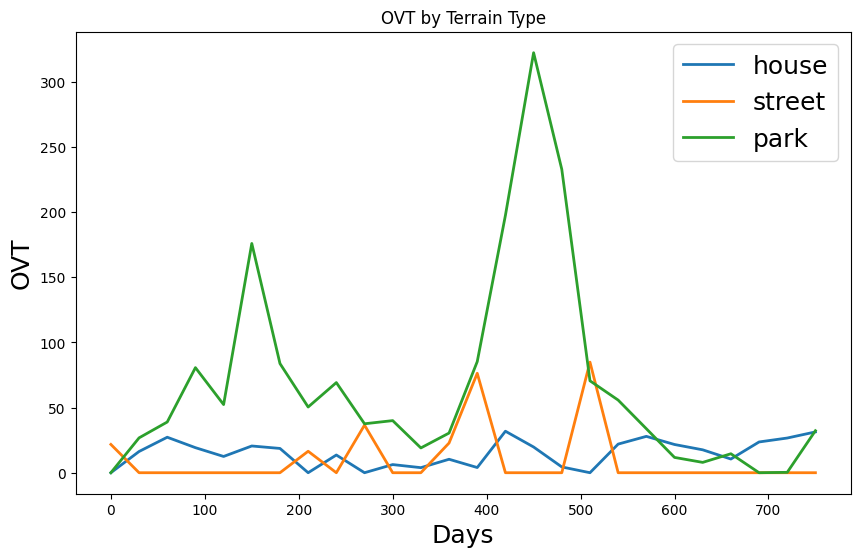

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data

In [24]:
matProporcoes[:-1,:]

matrix([[0.        , 0.07040021, 0.17270429, 0.7568955 ],
        [0.        , 0.06714785, 0.20136676, 0.73148539]])

In [25]:
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []
ADT_data = [AreiaADT, EmausADT, LiberdadeADT]

for t in range(len(days)):
    vetAdt = [ADT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua, ADT_parque, ADT_rua, ADT_casa = np.array(ADT_agua), np.array(ADT_parque), np.array(ADT_rua), np.array(ADT_casa)
print("ADT decomposition complete.")

ADT decomposition complete.


## 5. Validate Reconstruction

In [26]:
reconstructed_OVT = [np.zeros(len(days)) for _ in range(3)]
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    for i in range(3):
        reconstructed_OVT[i][t] = R[0, i]

print("Reconstruction Correlations (OVT):")
for i, name in enumerate(neighborhoods):
    corr = pearsonr(reconstructed_OVT[i], OVT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (OVT):
  Areia: 0.9131
  Emaus: 0.8511
  Liberdade: 0.9997


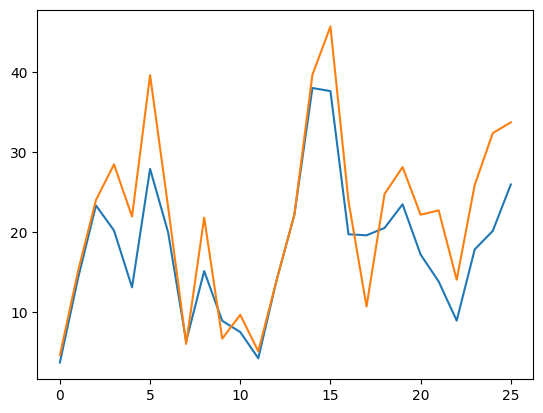

In [27]:
plt.plot(reconstructed_OVT[0])
plt.plot(AreiaOVT)

## 6. Save Results

In [28]:
data_new = {
    "Day": days,
    "OVT_house": O_casa,
    "OVT_park": O_parque,
    "OVT_street": O_rua,
    "ADT_house": ADT_casa,
    "ADT_park": ADT_parque,
    "ADT_street": ADT_rua,
    "Temperature": [hist.temperature(t) for t in days],
    "Pluviosity": [hist.pluviosity(t) for t in days]
}

df_new = pd.DataFrame(data_new)
df_new.to_csv("dataNew.csv", index=False)
print("Saved dataNew.csv")
df_new.head(10)

Saved dataNew.csv


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,0.000000,0.000000,21.722921,0.030315,0.077917,0.000000,25.678571428575,0.0
1,30,16.296291,26.752488,0.000000,0.008759,0.000000,0.000000,26.06726190475,21.15
2,60,27.243784,38.929672,0.000000,0.000000,0.000000,0.145432,26.334523809525,20.675
3,90,19.230432,80.667822,0.000000,0.006263,0.000168,0.120988,27.26273809525,14.725
4,120,12.487652,52.309771,0.000000,0.022915,0.059390,0.000000,27.10476190475,20.775
5,150,20.529086,175.990091,0.000000,0.009745,0.046990,0.059781,26.90875,38.125
6,180,18.642854,83.802732,0.000000,0.000000,0.000000,0.081835,26.778571428575,5.149999999999999
7,210,0.000000,50.442523,16.471620,0.000239,0.012806,0.139707,25.347857142849996,14.725
8,240,13.602873,69.194519,0.000000,0.000000,0.130907,0.094224,24.7325,17.275
9,270,0.000000,37.577140,36.540835,0.014744,0.303802,0.000000,24.5101190476,0.0
